# Efficiency Simulation

In [1]:
from __future__ import annotations
from dataclasses import dataclass

from coordinates import setup
setup("cuda:0")

from coordinates import Location, Checkpoint, device

import math as m
import copy
from collections.abc import Callable

from torch import FloatTensor, IntTensor, tensor
import torch
import torch.autograd.profiler as profiler
from tqdm.auto import tqdm

In [2]:
import pandas as pd
from coordinates import Checkpoint, Location

track_data = pd.read_csv("./sem_2023_us.csv")

track_data = track_data.rename(columns={
    "Metres above sea level": "Altitude"
})

track_data.head(10)

checkpoints: list[Checkpoint] = []
for i, row in track_data.iterrows():
    location = Location.construct(row["Latitude"], row["Longitude"], row["Altitude"])
    # print(f"Lat {row['Latitude']}, Long {row['Longitude']}, Alt {row['Altitude']}, x {location.x}, y {location.y}, z {location.z}")
    checkpoints.append(Checkpoint(location, location))

print(f"Found {len(checkpoints)} checkpoints")

Found 2696 checkpoints


1456.7204000013342


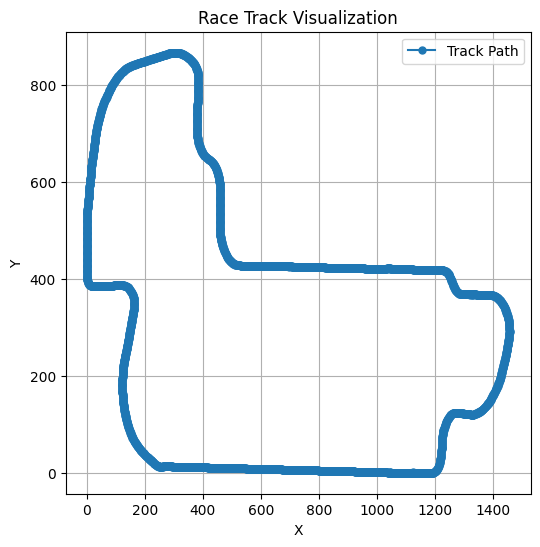

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y coordinates from the list of tensors
x = [t.points(1)[0][0].item() for t in checkpoints]
y = [t.points(1)[0][1].item() for t in checkpoints]

# Plot the race track
plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linestyle='-', markersize=5, label="Track Path")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Race Track Visualization")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
from graph import Graph, Node, Transition 

g = Graph.construct(
    checkpoints=checkpoints,
    n_points_per_checkpoint=1,
    max_velocity=42 * 1000 / 3600,  # Max velocity the car is allowed to go is 42 km/h
    velocity_step_size=7000 / 3600,
    wind_velocity=0,
    wind_bearing=0,
    motor_force=650, # Measured in Watts?
    brake_power=1000, # TODO: What would this be?
    mass=108, # KG
    coefficient_of_friction=0.03, # TODO: Figure this out
)

100%|██████████| 2695/2695 [00:27<00:00, 97.47it/s] 


In [5]:
import random

# Indianapolis Motor Speedway is approximatly 3.6km long

def get_graph_distance(graph: Graph) -> float:
    '''Returns the length of a random path through the graph'''

    distance = 0
    cursor = graph.start
    while cursor is not None:
        if len(cursor.transitions) == 0:
            cursor = None
        else:
            idx = random.randint(0, len(cursor.transitions) - 1)
            distance += Location.distance(cursor.position.reshape(1,3), cursor.transitions[idx].target.position.reshape(1,3))
            cursor = cursor.transitions[idx].target

    return distance[0]

distance = get_graph_distance(g)
print(f"Graph Distance: {distance.cpu().numpy() / 1000} km")


Graph Distance: 4.18882890187231 km


In [6]:
import heapq

def heuristic(distance_left: float, time_left: float, work_weight: float, time_weight: float) -> float:
    """
    Heuristic function for estimating the remaining cost.
    Replace this with an appropriate heuristic based on your graph.
    """
    # 103 = mass of car
    
    # 0.75 is safety to not overestimate, need to adjust?
    velocity = distance_left / time_left * 0.75
    work = 0.5 * 108 * velocity * velocity * distance_left
    return work * work_weight + time_left * time_weight

def cheapest_path_a_star(graph: Graph, work_weight: float, time_weight: float):
    # Priority queue for A* search: (cost, node_id, time, energy, path, distance)
    pq = []
    heapq.heappush(pq, (0, graph.start.id, 0, 0, [graph.start.id], 0))
    
    # Track the best costs to nodes
    min_cost = {node_id: float('inf') for node_id in graph.nodes.keys()}
    min_cost[graph.start.id] = 0

    # A* Search
    while pq:
        current_cost, current_id, current_time, current_energy, current_path, current_distance = heapq.heappop(pq)
        current_node = graph.nodes[current_id]

        # Stop if we've reached the target
        if current_id == graph.end.id:
            return current_path, current_cost, current_time, current_energy

        # Explore neighbors
        for transition in current_node.transitions:
            neighbor_id = transition.target.id
            new_time = current_time + transition.time_required
            new_energy = current_energy + transition.work_required

            # Calculate the new weighted cost
            weighted_cost = work_weight * new_energy + time_weight * new_time

            # Combine with heuristic for A* priority
            heuristic_cost = heuristic(distance - current_distance, 34 * 60 - current_time, work_weight, time_weight)
            total_cost = weighted_cost + heuristic_cost

            # Update if this path is better
            if weighted_cost < min_cost[neighbor_id]:
                min_cost[neighbor_id] = weighted_cost
                new_path = current_path + [neighbor_id]
                heapq.heappush(pq, (total_cost, neighbor_id, new_time, new_energy, new_path, current_distance + Location.distance_with_z(current_node.position, transition.target.position)))

    raise ValueError("No path found within reasonable time.")

def topological_order(graph: Graph) -> list[int]:
    '''Returns the ids in topo order'''
    # Topological sorting using DFS
    topological_order: list[int] = []
    marked_nodes: set[int] = set() # Used to track visited nodes

    def visit(node: Node):
        if node.id in marked_nodes:
            return

        for transition in node.transitions:
            visit(transition.target)

        marked_nodes.add(node.id)
        topological_order.insert(0, node.id)

    # Generate the topological order
    for node_id in graph.nodes.keys():
        if node_id not in marked_nodes:
            visit(graph.nodes[node_id])

    return topological_order

def cheapest_path(graph: Graph, work_weight: float, time_weight: float):
    # Topological sorting using DFS
    sorted_nodes = topological_order(graph)

    # Get all node ids
    node_ids = list(graph.nodes.keys())

    # Initialize cost and time dictionaries
    min_cost  = {node_id: float('inf') for node_id in node_ids}
    min_energy  = {node_id: float('inf') for node_id in node_ids}
    min_time = {node_id: float('inf') for node_id in node_ids}
    prev_node = {node_id: None for node_id in node_ids}

    min_cost[graph.start.id] = 0
    min_energy[graph.start.id] = 0
    min_time[graph.start.id] = 0

    # Iterate through nodes in topological order
    for node_id in sorted_nodes:
        current_node = graph.nodes[node_id]

        for transition in current_node.transitions:
            neighbor_id = transition.target.id
            new_time = min_time[node_id] + transition.time_required
            new_energy = min_energy[node_id] + transition.work_required

            # Calculate the new weighted cost
            weighted_cost = work_weight * new_energy + time_weight * new_time

            # Check if the new path offers a lower cost
            if weighted_cost < min_cost[neighbor_id]:
                min_cost[neighbor_id] = weighted_cost
                min_time[neighbor_id] = new_time
                min_energy[neighbor_id] = new_energy
                prev_node[neighbor_id] = node_id

    # Find the minimum cost path to the end node
    if min_cost[graph.end.id] == float('inf'):
        raise ValueError("No path found within reasonable time.")
    
    # Reconstruct the path
    path = []
    node_id = graph.end.id
    while node_id is not None:
        path.append(node_id)
        node_id = prev_node[node_id]

    path.reverse()  # Reverse to get the correct order from start to end
    return path, min_cost[graph.end.id], min_time[graph.end.id], min_energy[graph.end.id]

In [10]:
energy_weight = 1
time_weight = 1

node_ids, cost, time, energy = cheapest_path(g, energy_weight, time_weight)

# while time > 11 * 60:
#     print(time)
#     time_weight += 1
#     node_ids, cost, time, energy = cheapest_path(g, energy_weight, time_weight)

# print(time_weight)

distance = 0
last_node = node_ids[0]
for node in node_ids[1:]:
    a = g.get_node(last_node)
    b = g.get_node(node)

    if a is not None and b is not None:
        distance += Location.distance(a.position.reshape(1,3), b.position.reshape(1,3))[0]
    else:
        print("Skip")
    last_node = node

def kilo_watt_hour(joules: float):
    return joules / 3600000

effiency = (distance / 1000) / kilo_watt_hour(energy)

print(f"Energy {energy/1000} kJ | Energy {kilo_watt_hour(energy)} kWh | Time {time / 60} minutes | Cost {cost} | Efficiency {effiency}km/kWh | Distance: {distance / 1000} km")
# # Energy 120.8918601709963 kJ | Energy 0.03358107226972119 kWh | Time 33.65325516771226 minutes | Cost 122935.56594343994 | Efficiency 106.22660349486436km/kWh | Distance: 3.5672032489280583 km


Energy 12492.16131803684 kJ | Energy 3.4700448105657884 kWh | Time 189.38215995399736 minutes | Cost 13628454.277760824 | Efficiency 1.2065884387955768km/kWh | Distance: 4.186915950531268 km


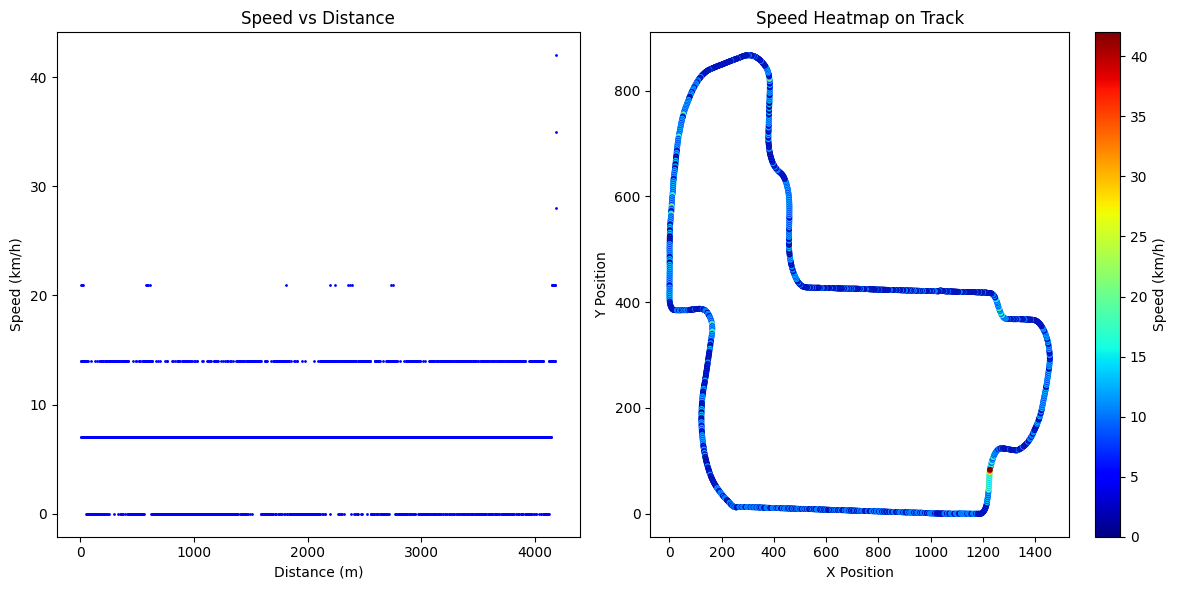

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Collect positions, distances, and velocities
positions = []
velos = []
distances = []

distance = 0
last_node = node_ids[0]

for node in node_ids[1:]:
    a = g.get_node(last_node)
    b = g.get_node(node)

    if a is not None and b is not None:
        distance += Location.distance(a.position.reshape(1,3), b.position.reshape(1, 3))[0]
        positions.append(b.position.cpu().numpy()[:2])  # Extract x, y only
        velos.append(b.velocity.cpu().numpy() * 3600 / 1000)  # Convert to km/h
        distances.append(distance.cpu())
    else:
        print("Skip")
    
    last_node = node

positions = np.array(positions)
velos = np.array(velos)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left Plot: Speed vs. Distance
axes[0].scatter(distances, velos, s=1, color="blue")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Speed (km/h)")
axes[0].set_title("Speed vs Distance")

# Right Plot: Speed Heatmap on Track
sc = axes[1].scatter(positions[:, 0], positions[:, 1], c=velos, cmap="jet", s=10)
axes[1].set_xlabel("X Position")
axes[1].set_ylabel("Y Position")
axes[1].set_title("Speed Heatmap on Track")
fig.colorbar(sc, ax=axes[1], label="Speed (km/h)")

plt.tight_layout()
plt.show()
